In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from django.db.models import Count, OuterRef, Subquery, F, Sum, IntegerField
from django_pandas.io import read_frame

In [88]:
# filter clothing tasks
tasks = Task.objects.filter(name__contains='پوشاک ')

completed_jobs = Job.objects.filter(status__in=['validation', 'completed'], segment__task__in=tasks)

labeled_shapes = LabeledShape.objects.filter(job=OuterRef('pk')).values('job')
total_shapes = labeled_shapes.annotate(count=Count('pk')).values('count')

reports = JobFrameComment.objects.filter(job=OuterRef('pk')).values('job')
total_reports = reports.annotate(count=Count('pk')).values('count')

last_commits = JobCommit.objects.filter(job=OuterRef('pk')).order_by('-timestamp')
last_commit_subquery = Subquery(last_commits.values('timestamp__date')[:1])

annotated_jobs = completed_jobs.annotate(
    image_count=F('segment__stop_frame') - F('segment__start_frame') + 1,
    shapes_count=Subquery(total_shapes),
    reports_count=Subquery(total_reports),
    last_commit_date=last_commit_subquery
)

annotated_jobs.aggregate(
    Sum('image_count'), 
    Sum('shapes_count', output_field=IntegerField()), 
    Sum('reports_count', output_field=IntegerField())
)

{'image_count__sum': 47141,
 'reports_count__sum': 3279,
 'shapes_count__sum': 57231}

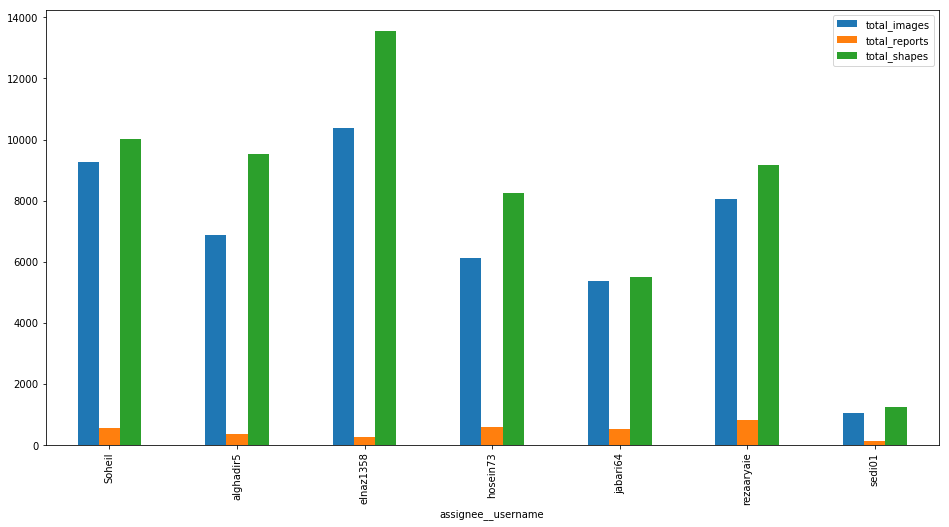

In [89]:
# operators stats
user_stats = annotated_jobs.values('assignee__username').annotate(
    total_images=Sum('image_count'),
    total_shapes=Sum('shapes_count', output_field=IntegerField()),
    total_reports=Sum('reports_count', output_field=IntegerField())
)
df = read_frame(user_stats)
df.plot(kind='bar', x='assignee__username', figsize=(16, 8))

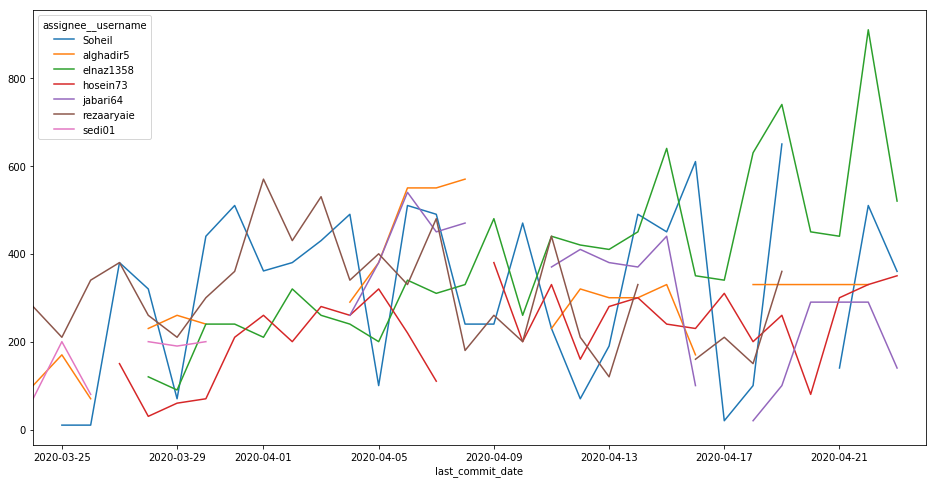

In [90]:
# operators daily stats
user_daily_stats = annotated_jobs.values('assignee__username', 'last_commit_date').annotate(
    total_images=Sum('image_count'),
)
df = read_frame(user_daily_stats)
df.groupby(['last_commit_date', 'assignee__username']).sum().unstack().plot(kind='line', y='total_images', figsize=(16, 8))

In [97]:
# operators mean stats
user_daily_stats = annotated_jobs.values('assignee__username', 'last_commit_date').annotate(
    total_images=Sum('image_count'),
)
df = read_frame(user_daily_stats)
df.groupby('assignee__username').agg({
    'last_commit_date': ['count'],
    'total_images': ['sum', 'mean']
})

total_images             last_commit_date
                            sum        mean            count
assignee__username                                          
Soheil                     9271  319.689655               29
alghadir5                  6870  298.695652               23
elnaz1358                 10380  384.444444               27
hosein73                   6120  226.666667               27
jabari64                   5380  298.888889               17
rezaaryaie                 8060  298.518519               27
sedi01                     1060  132.500000                8

In [106]:
# Get shapes annotated stats
labeled_shapes = LabeledShape.objects.filter(label=OuterRef('pk')).values('label')
total_shapes = labeled_shapes.annotate(count=Count('pk')).values('count')

labels = Label.objects.filter(task__in=tasks).annotate(
    shapes_count=Subquery(total_shapes)).filter(shapes_count__gte=1).values('name').annotate(
    count=Sum('shapes_count', output_field=IntegerField())).order_by('-count')

read_frame(labels).style.hide_index()

name,count
لباس‌مجلسي,10170
مانتو,6624
کاپشن,3652
شلوار,3031
پالتو,2812
کت,2639
لباس زنانه,1534
تيشرت,1424
لباس‌عروس,1347
دامن,1318
